# Speech Emotion Recognition: Data Augmentation and Feature Extraction

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

#### Import emotion dataset

In [2]:
# Import combined dataframes (created using the'combine_datasets.ipynb' notebook)
emotion_df = pd.read_csv('./emotion_df.csv')
emotion_df

,File,Emotion
0,CREMA/AudioWAV/1001_DFA_ANG_XX.wav,angry
1,CREMA/AudioWAV/1001_DFA_DIS_XX.wav,disgust
2,CREMA/AudioWAV/1001_DFA_FEA_XX.wav,fear
3,CREMA/AudioWAV/1001_DFA_HAP_XX.wav,happy
4,CREMA/AudioWAV/1001_DFA_NEU_XX.wav,neutral
...,...,...
39453,MELD/train_splits_audio\dia1038_utt13.wav,neutral
39454,MELD/train_splits_audio\dia1038_utt14.wav,neutral
39455,MELD/train_splits_audio\dia1038_utt15.wav,surprise
39456,MELD/train_splits_audio\dia1038_utt16.wav,neutral


#### Audio playback

In [3]:
# Verify audio files loads correctly using the dataset paths by opening and playing the first file (001_DFA_ANG_XX)
data,sr = librosa.load(emotion_df['File'].iloc[0])
ipd.Audio(data,rate=sr)

## Data Augmentation

In [4]:
# Noise: Add randomised noise to audio signal
def add_noise(data):
    # Generate noise and add it to the input audio signal
    amp = 0.025 * np.random.uniform() * np.amax(data) # Generate noise
    return data + amp * np.random.normal(size=data.shape) # Apply to the input audio signal

# Dynamic compression: Apply dynamic compression to reduce volume spikes
def dynamic_compression(data, threshold=0.1, ratio=1.5):
    mask = np.abs(data) > threshold # Create mask using absolute signal value and threshold parameter 
    # Apply compression to values above the threshold
    compressed_data = np.where(mask, 
                               threshold + (data - threshold) / ratio, 
                               data)  
    return compressed_data

# Pitch shift: Shift the pitch of the input audio signal
def pitch_shift(data, sampling_rate):
    pitch_factor = np.random.uniform(-0.5, 0.5)  # Randomize pitch shift (-0.5 to 0.5)
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor) # Apply to the input audio signal


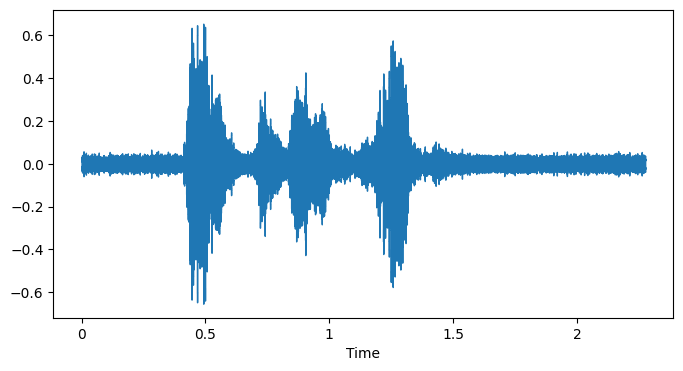

In [5]:
# Test data augmentations
audio_aug = add_noise(data) # Noise augmentation 
#audio_aug = pitch_shift(data, sr)  # Pitch shift augmentation 
#audio_aug = dynamic_compression(data) # Dynamic compression augmentation

# Plot and audio playback
plt.figure(figsize=(8, 4)) 
librosa.display.waveshow(y=audio_aug, sr=sr)
ipd.Audio(audio_aug, rate=sr)

## Extract Audio Features

In [6]:
# Calculate average duration and initial silence
# Use a sample of 20% of the dataset due to computational requirements (i.e., the datasets is roughly 39.000 entries)
sample_df = emotion_df.sample(frac=0.2, random_state=42)

# Function to calculate duration and initial silence
def calculate_duration_and_silence(file):
    try:
        # Load audio files using the filepath 
        data, sr = librosa.load(file, sr=None)
        
        # Calculate duration
        duration = librosa.get_duration(y=data, sr=sr)
        
        # Calculate initial silence
        non_silent_intervals = librosa.effects.split(data, top_db=10)
        initial_silence = non_silent_intervals[0][0] / sr if non_silent_intervals.size > 0 else 0
        
        return duration, initial_silence
    except Exception as e:
        print(f"Error processing {file}: {e}")
        return np.nan, np.nan

# Apply function to sample dataframe and create duration and silence columns
sample_df[['duration', 'initial_silence']] = sample_df['File'].apply(calculate_duration_and_silence).apply(pd.Series)

# Calculate the average duration and silence
avg_duration = sample_df['duration'].mean()
avg_initial_silence = sample_df['initial_silence'].mean()

# Print duration and silence averages
print(f"Average Duration: {avg_duration:.2f} seconds")
print(f"Average Initial Silence: {avg_initial_silence:.2f} seconds")

Average Duration: 2.81 seconds
Average Initial Silence: 0.39 seconds


In [11]:
# Feature extraction function (applies data augmentation and extracts relevant features using using ZCR, RMS, and MFCC.)
def extract_audio_features(file, emotion):
    try:
        #Load audio file using the average duration and initial silence obtained
        data, sr = librosa.load(file, duration=avg_duration, offset=avg_initial_silence)
    except Exception as e:
        print(f"Error loading audio file {file}: {e}")
        return np.array([]), []

    # List containing data augmentation functions 
    augmentations = [
        ("Original", lambda x: x), # Orignal audio
        ("Noise", add_noise), # Noise augmentation
        ("Dynamic Compression", lambda x: dynamic_compression(x)), # Dynamic compression augmentation
        ("Dynamic Compression and Noise", lambda x: add_noise(dynamic_compression(x))), # Dynamic compression + noise augmentation
        ("Pitch Shift", lambda x: pitch_shift(x, sr)), # Pitch shift augmentation
        ("Pitch Shift and Noise", lambda x: add_noise(pitch_shift(x, sr))), # Pitch shift + noise augmentation
    ]

    # Initialize list for audio features
    audio_features = []

    # Iterate augmentations to apply and extract audio features
    for name, augmentation in augmentations:
        try:
            # Apply augmentation
            augmented_data = augmentation(data)
            '''
            # Handle augmentations resulting in empty audio
            if len(augmented_data) == 0:
                print(f"Warning: {name} audio is empty.")
                continue
            '''
            
            # Extract features audio with augmentation applied using ZCR, RMS, and MFCC.
            try:
                features = np.hstack((
                    np.squeeze(librosa.feature.zero_crossing_rate(augmented_data, frame_length=2048, hop_length=512)), # Extract zero-crossing rate
                    np.squeeze(librosa.feature.rms(y=augmented_data, frame_length=2048, hop_length=512)),  # Extract root-mean-square
                    np.squeeze(np.ravel(librosa.feature.mfcc(y=augmented_data, sr=sr, n_fft=2048, hop_length=512).T))  # Extract Mel-frequency cepstral coefficients
                ))
                # Only append to audio features list if features are succesfully extracted
                if features.size > 0:
                    audio_features.append(features)
                else:
                    print(f"Warning: No features extracted from {name} audio.")
            except ValueError as e:
                print(f"Error in feature extraction: {e}")
                continue
        except Exception as e:
            print(f"Error processing {name} audio: {e}")
            continue

    # Vertically stack features along with the corresponding emotion label
    if audio_features:
        return np.vstack(audio_features), [emotion] * len(audio_features)
    else:
        print("Warning: No features extracted, returning empty array.")
        return np.array([]), []

In [12]:
# Parallel feature extraction across all files using all available CPU cores ('n_jobs-1')
extracted_features = Parallel(n_jobs=-1)(
    delayed(extract_audio_features)(file, emotion) for file, emotion in zip(emotion_df.File, emotion_df.Emotion)
)

# Unpack extracted audio features into X and Y lists
X, Y = zip(*extracted_features)

# Flatten X (features) and Y (emotion labels)
X = [feature for features in X for feature in features]
Y = [label for labels in Y for label in labels]

# Print length of X, Y, and emotion_df to verify features have been extracted
len(X), len(Y), emotion_df.Emotion.shape

(235476, 235476, (39458,))

In [13]:
# Convert X (list of extracted features) into a DataFrame and add the emotion labels (Y)
feature_df = pd.DataFrame(X).assign(Emotion=Y)

# Handle potential NaNs
print("Total NaNs before handling:", feature_df.isna().sum().sum())
feature_df = feature_df.fillna(0)
print("Total NaNs after handling:", feature_df.isna().sum().sum())

# Print feature dataframe header
feature_df.head()

Total NaNs before handling: 153552168
Total NaNs after handling: 0


,0,1,2,3,4,5,6,7,8,9,...,2675,2676,2677,2678,2679,2680,2681,2682,2683,Emotion
0,0.058594,0.092285,0.115723,0.106445,0.087891,0.066406,0.049805,0.043945,0.038086,0.054199,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,angry
1,0.129883,0.161621,0.187012,0.113281,0.092773,0.073242,0.057617,0.061523,0.084961,0.147949,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,angry
2,0.058594,0.092285,0.115723,0.106445,0.087891,0.066406,0.049805,0.043945,0.038086,0.054199,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,angry
3,0.083984,0.117676,0.141113,0.109375,0.089844,0.068359,0.051758,0.045898,0.041016,0.061035,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,angry
4,0.061035,0.092285,0.115723,0.103516,0.084961,0.063965,0.048340,0.041992,0.035645,0.050781,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,angry


## Save Extracted Features

In [2]:
# Save to disc as csv format (used to train the model)
# NOTICE: The file size is approx. 9.4 GB
#feature_df.to_csv('extracted_features.csv', index=False)